In [1]:
#import common modules
import os
import sys
import math
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

# import flow modules
import class_definitions as cd
import function_definitions as fd

# import fish utility modules
import airfoil as ar
import fishUtilities as fu
import fishFits as ff

from scipy import integrate

First we use the utililites written with Open CV2 to get the contours of the fish `paper to come`. We must pre-process the pictures before image segmentation and define the path.

In [2]:
imagePath = r'D:\Dropbox\UUV Project\Pictures\powerThrustData\UV Tunabot'
#imagePath = r'C:\Documents\Dropbox\UUV Project\Pictures\powerThrustData\UV Tunabot'

specimen = 'UVTunabot'

# reported data
# total length
t_length = 0.2553
# width and height
width = 0.0492
height = 0.0678
# mass
mass = 0.306

In [3]:
imagePathTop = fu.get_image_files(imagePath, specimen+'Top.PNG')
imagePathSide = fu.get_image_files(imagePath, specimen+'SideNF.PNG')
imagePathSideFull = fu.get_image_files(imagePath, specimen+'Side.PNG')
    
# import images
imageTop = cv2.imread(imagePathTop[0])
imageSide = cv2.imread(imagePathSide[0])
imageSideFull = cv2.imread(imagePathSideFull[0])
    
# make a copy of the image
sideImage = imageSide.copy()
topImage = imageTop.copy()
sideImageFull = imageSideFull.copy()
        
# get contours
cntsTop, hullTop = fu.get_contours(imageTop, 1)
cntsSide, hullSide = fu.get_contours(imageSide, 1)
cntsFull, hullFUll = fu.get_contours(imageSideFull, 1)
    
# determine the most extreme points along the contour
extSideLeft = tuple(cntsSide[cntsSide[:, :, 0].argmin()][0])
extSideRight = tuple(cntsSide[cntsSide[:, :, 0].argmax()][0])
extTopLeft = tuple(cntsTop[cntsTop[:, :, 0].argmin()][0])
extTopRight = tuple(cntsTop[cntsTop[:, :, 0].argmax()][0])
extTop = tuple(cntsFull[cntsFull[:, :, 1].argmin()][0])
extBot = tuple(cntsFull[cntsFull[:, :, 1].argmax()][0])
    
# Find the area ratio of fins and no fins
areaFull = cv2.contourArea(cntsFull)
areaNF = cv2.contourArea(cntsSide)
areaRatio = (1-np.abs(areaNF/areaFull))
    
# split the hull into top and bottom
(cxTop, cyTop), topHullTop, bottomHullTop = fu.split_by_centroid_top(imageTop.shape, cntsTop)
(cxSide, cySide), areaSide, topHullSide, bottomHullSide = fu.split_by_centroid_side(imageSide.shape, cntsSide)
(cxFull, cyFull), areaSideFull, topHullSideFull, bottomHullSideFull = fu.split_by_centroid_side(imageSideFull.shape, cntsFull)
    
# get contour data
areaTop, tHullTop, bHullTop = fu.scale_data_top(topHullTop, bottomHullTop)
scaleFactorSide, tHullSide, bHullSide = fu.scale_data(topHullSide, bottomHullSide)
scaleFactorSideFull, tHullSideFull, bHullSideFull = fu.scale_data(topHullSideFull, bottomHullSideFull)
        
#areaTopRatio = 1-(areaTop/areaTopFull)
# get min and max points
maxPointsTop, minPointsTop = fu.get_min_max(tHullTop, bHullTop)
maxPointsSide, minPointsSide = fu.get_min_max(tHullSide, bHullSide)
        
# half-cosine spacing
chord = 1.0
beta = np.linspace(0, np.pi, 20)
#dx = (0.5*(1-np.cos(beta)))
# uniform spacing
dx = np.linspace(0.0, chord, 200)

# fit data
topPolyArea, topFitTop, bottomFitTop = ff.fit_top_contours_poly(tHullTop, bHullTop, 6)
topFitSide, bottomFitSide = ff.fit_side_contours(tHullSide, bHullSide, 6)
nacaArea, m, t, d0, xu, yu, xl, yl = ff.fit_top_contours(areaTop, dx, np.mean([minPointsTop[0],maxPointsTop[0]]),
                                                 np.abs(minPointsTop[1])+maxPointsTop[1], (tHullTop[1,-5]+np.abs(bHullTop[1,-5]))/2.0)
topPolyTop = np.poly1d(topFitTop)
bottomPolyTop = np.poly1d(bottomFitTop)
topPolySide = np.poly1d(topFitSide)
bottomPolySide = np.poly1d(bottomFitSide)


Lets plot the full top and side contour

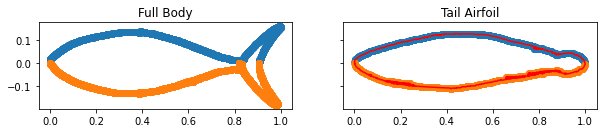

In [4]:
x_hull_top = np.concatenate((np.flipud(tHullTop[0]), bHullTop[0]))
y_hull_top = np.concatenate((np.flipud(tHullTop[1]), bHullTop[1]))

# plot the two airfoils
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20), sharey=True)
ax1.plot(tHullSideFull[0], tHullSideFull[1], 'o')
ax1.plot(bHullSideFull[0], bHullSideFull[1], 'o')
ax1.set_title('Full Body')
ax1.set_aspect('equal')
ax2.plot(tHullTop[0], tHullTop[1], 'o')
ax2.plot(bHullTop[0], bHullTop[1], 'o')
ax2.plot(x_hull_top, y_hull_top, 'r')
ax2.set_title('Tail Airfoil')
ax2.set_aspect('equal')

First we use the airfoil script to make two airfoils. The first airfoil is the body and the second is the tail. 

The body is a modified naca4 airfoil using the function `naca4_modified(x, t, m, d0, c)` where,
    **x** is a 1D numpy array of x-coordinates,
    **t** is the maximum thickness,
    **c** is the chord length,  
    **m** is a float of the location of maximum thickness, and 
    **d0** is the thickness of the trailing edge.

The tail is a symmetric naca4 airfoil using the function `naca4(x, t, m, p, a4, c)` where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.
    
Notice that the `convert_to_coordinates` method is called to put the data in the format of a .dat file

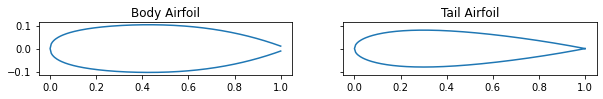

In [5]:
x, y = ar.naca4_modified(dx, t, m, d0, chord)
X_body, Y_body = ar.convert_to_coordinates(x, y)
x, y = ar.naca4(dx, 0.16, 0.0, 0.3, True, chord)
X_tail, Y_tail = ar.convert_to_coordinates(x, y)

# plot the two airfoils
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,20), sharey=True)
ax1.plot(X_body, Y_body)
ax1.set_title('Body Airfoil')
ax1.set_aspect('equal')
ax2.plot(X_tail, Y_tail)
ax2.set_title('Tail Airfoil')
ax2.set_aspect('equal')

Scale the tail down to what the aspect ratio is and place it at the standard length of the fish / robot. Use the airfoil to construct a top projection.

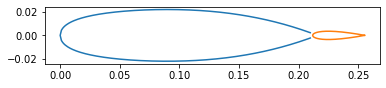

In [6]:
c_tail_length = 0.043478
s_length = 0.8217 * t_length

X_body = X_body * s_length
Y_body = Y_body * s_length
X_tail = X_tail * c_tail_length
Y_tail = Y_tail * c_tail_length

x_hull_top = x_hull_top * s_length
y_hull_top = y_hull_top * s_length

# new coordinates for the tail
X_tail = X_tail - X_tail[0] + t_length

f2, ax2 = plt.subplots()
ax2.plot(X_body, Y_body)
ax2.plot(X_tail, Y_tail)
ax2.set_aspect('equal')

Get a projected view in one coordinate system.  Remember that the .dat file goes around the airfoils counter-clockwise

0.04336942944983143


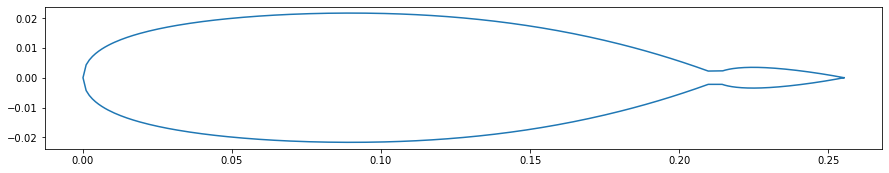

In [7]:
# Give total width to ensure proper scaling
width = np.amax(Y_body) + np.abs(np.amin(Y_body))
print(width)

# subtract the overlapping regions
o_region_plus = np.where(Y_tail >= Y_body[0])[0][-1]
o_region_minus = np.where(Y_tail <= Y_body[-1])[0][0]
mask = np.ones(Y_tail.size, dtype=bool)
mask[o_region_plus:o_region_minus] = False

X_tail_proj = X_tail[mask] 
Y_tail_proj = Y_tail[mask]

# find the half index to combine both airfoils into one coordinate system
half_tail = int(len(X_tail_proj)/2)

# combine into the projected frame
X_proj = np.concatenate((X_tail_proj[0:(half_tail)], X_body, X_tail_proj[(half_tail)::]))
Y_proj = np.concatenate((Y_tail_proj[0:(half_tail)], Y_body, Y_tail_proj[(half_tail)::]))

f3, ax3 = plt.subplots(figsize=(15, 15))
ax3.plot(X_proj, Y_proj)
ax3.set_aspect('equal')

Perform the same above operations for the contours

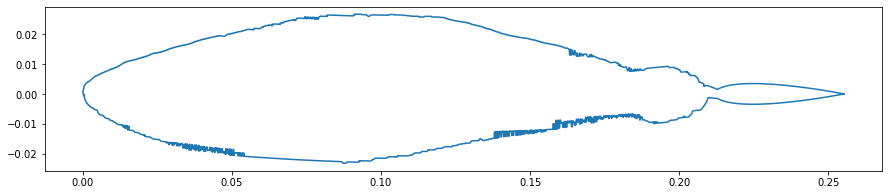

In [8]:
# find the half index to combine both airfoils into one coordinate system
half_tail = int(len(X_tail)/2)

# make a small change to the end of the body to make it more uniform and smoother transition
connector_width = 0.0055 / 2
y_hull_top[0:10] = connector_width
y_hull_top[-1:-10] = -connector_width


# combine into the projected frame
X_proj_contour = np.concatenate((X_tail[0:(half_tail-5)], x_hull_top, X_tail[(half_tail+5)::]))
Y_proj_contour = np.concatenate((Y_tail[0:(half_tail-5)], y_hull_top, Y_tail[(half_tail+5)::]))

f4, ax4 = plt.subplots(figsize=(15, 15))
ax4.plot(X_proj_contour, Y_proj_contour)
ax4.set_aspect('equal')

Output the coordinate text file to a csv file. The proper format depending on the modeler is the following:

**Spaceclaim:** columns of z, x, y

**DesignModeler:** columns of group, point number, x, y, z

In [10]:
output_file_airfoilDM = './UVTuna_airfoilDM.csv'
output_file_contourDM = './UVTuna_contourDM.csv'
output_file_airfoilSC = './UVTuna_airfoilSC.csv'
output_file_contourSC = './UVTuna_contourSC.csv'

for file in [output_file_airfoilDM, output_file_contourDM, output_file_airfoilSC, output_file_contourSC]:
    if os.path.exists(file):
        os.remove(file)

# for spaceclaim coordinates
output_data = np.array(list(zip(np.zeros(len(X_proj)), X_proj, Y_proj)))
np.savetxt(output_file_airfoilSC, output_data, delimiter=',', fmt='%f', header='Polyline=True' )
output_data = np.array(list(zip(np.zeros(len(X_proj_contour)), X_proj_contour, Y_proj_contour)))
np.savetxt(output_file_contourSC, output_data, delimiter=',', fmt='%f', header='Polyline=True' )

# for design modeler coordinates
output_data = np.array(list(zip(np.ones(len(X_proj)),np.arange(1, len(X_proj), 1), 
                                X_proj, Y_proj, np.zeros(len(X_proj), dtype=float))))
np.savetxt(output_file_airfoilDM, output_data, delimiter=',', fmt='%f', header='Group, Points, X-coord, Y-coord, Z-coord')
output_data = np.array(list(zip(np.ones(len(X_proj_contour)),np.arange(1, len(X_proj_contour), 1), 
                                X_proj_contour, Y_proj_contour, np.zeros(len(X_proj_contour), dtype=float))))
np.savetxt(output_file_contourDM, output_data, delimiter=',', fmt='%f', header='Group, Points, X-coord, Y-coord, Z-coord')